In [57]:
import numpy as np
import math
import random
import matplotlib.pyplot as plt
from matplotlib import cm

%matplotlib inline
params = {"ytick.color" : "c",
          "xtick.color" : "c",
          "axes.labelcolor" : "c",
          "axes.edgecolor" : "c",
         "text.color" : "c"}
plt.rcParams.update(params)#setup for dark theme

import pandas as pd
#from numpy import linalg
#from sklearn.decomposition import PCA
#from scipy.io import loadmat

#from numpy import linalg as LA
#from matplotlib.patches import Ellipse
#import matplotlib.transforms as transforms

from collections import defaultdict
#from PIL import Image
#from sklearn.metrics.pairwise import euclidean_distances
from sklearn.model_selection import train_test_split

import scipy.stats as sstats 
#from tqdm import tqdm
from sklearn import (datasets, decomposition, ensemble, manifold, random_projection)

Zadanie 6. (4 punkty)
W pakiecie SciKit do Pythona dostępnych jest kilka popularnych metod redukcji
wymiarowości i manifold learning (czyli metod wyznaczania rozmaitości różniczkowalnej,
na której znajdują się rozpatrywane dane). Zapoznaj się z nimi wykonując skrypt
umieszczony w materiałach do wykładu. Sprawdź jaki wpływ na działanie tych metod mają
ich parametry.

In [2]:
def plot_digits(X, y):
    X = (X - np.min(X, 0)) / (np.max(X, 0) - np.min(X, 0))
    plt.figure(figsize=(12, 9))
    for i in range(X.shape[0]):
        plt.text(X[i, 0], X[i, 1], str(y[i]), color=plt.cm.Set1(0.1*y[i]), 
                 fontdict={'weight':'bold', 'size':8})
    plt.xticks([])
    plt.yticks([])
    plt.show()

In [9]:
#Wczytywanie danych - dataset.digits
digits = datasets.load_digits()
X = digits.data
y = digits.target
N, d = X.shape
print(X[0,:])

[ 0.  0.  5. 13.  9.  1.  0.  0.  0.  0. 13. 15. 10. 15.  5.  0.  0.  3.
 15.  2.  0. 11.  8.  0.  0.  4. 12.  0.  0.  8.  8.  0.  0.  5.  8.  0.
  0.  9.  8.  0.  0.  4. 11.  0.  1. 12.  7.  0.  0.  2. 14.  5. 10. 12.
  0.  0.  0.  0.  6. 13. 10.  0.  0.  0.]


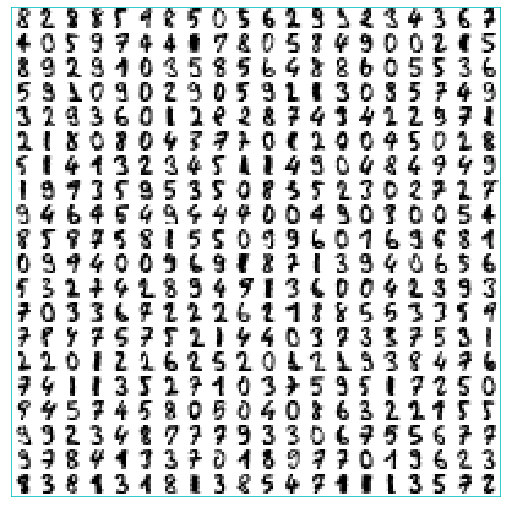

In [5]:
M = 20
image = np.zeros((10 * M, 10 * M))
order = np.random.permutation(N)
for i in range(M):
    for j in range(M):
        image[10*i+1:10*i+9, 10*j+1:10*j+9] = X[order[i*M+j], :].reshape((8, 8))

plt.figure(figsize=(9, 9))
plt.imshow(image, cmap=plt.cm.binary)
plt.xticks([])
plt.yticks([])
plt.show()

random projection

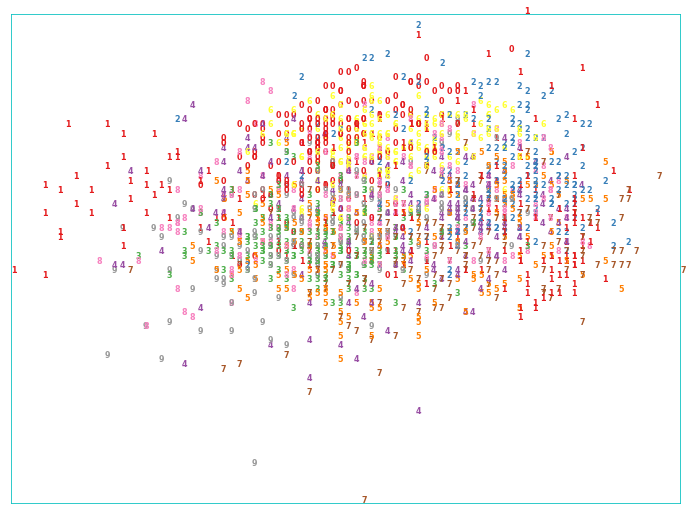

In [20]:
#rzut na dwie losowe osie
X_projected = random_projection.SparseRandomProjection(n_components=2, density='auto', dense_output=True).fit_transform(X)
plot_digits(X_projected, digits.target)
#low density - vertical lines, default auto ratio of non zero component
#dense_output - kontrola gestosci

Principal Component Analysis

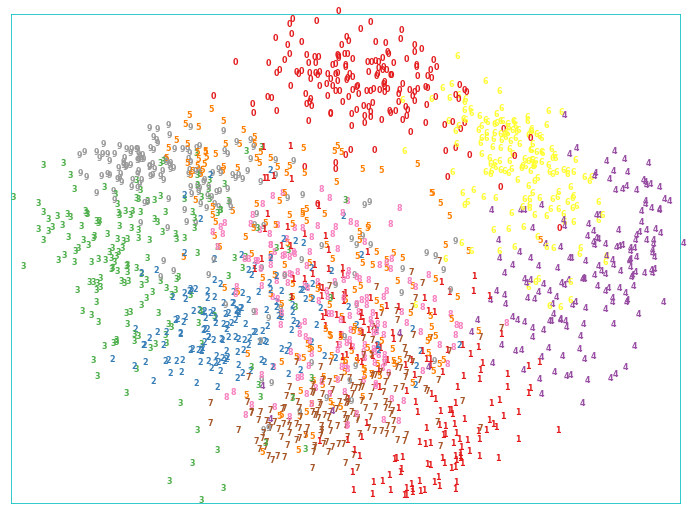

In [25]:
#pca
#svd singular value decomposition
X_pca = decomposition.PCA(n_components=20,whiten=True,svd_solver='randomized').fit_transform(X)
plot_digits(X_pca, digits.target)
#whiten ensure uncorrelated outputs with unit component-wise variances.
#svd solver  - params dokompozycji

Kernel Principal Component Analysis

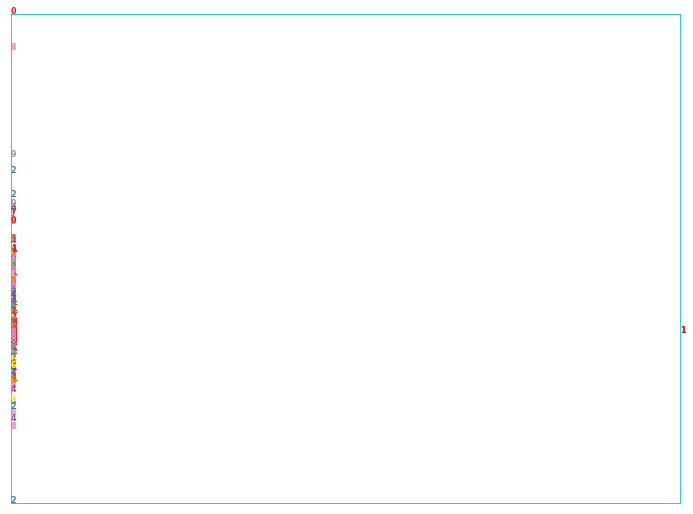

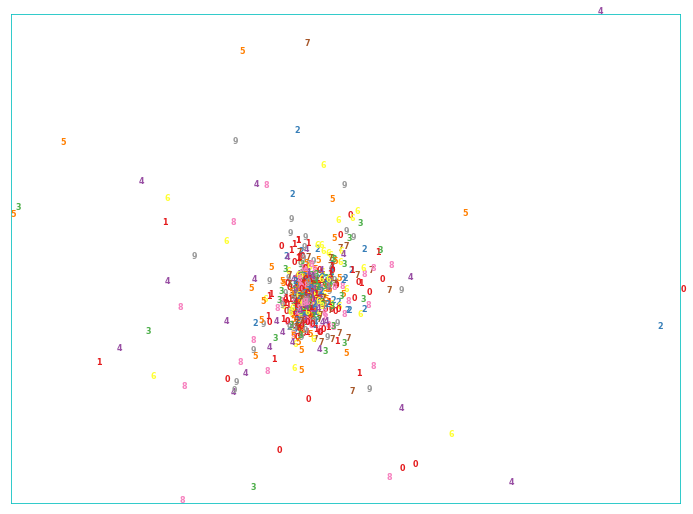

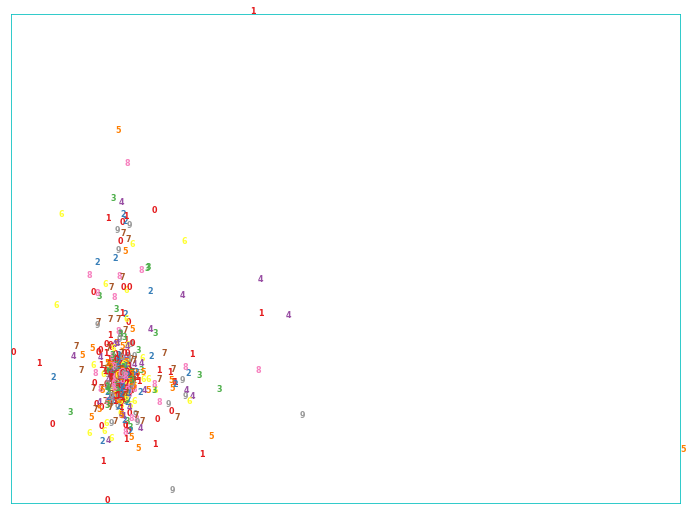

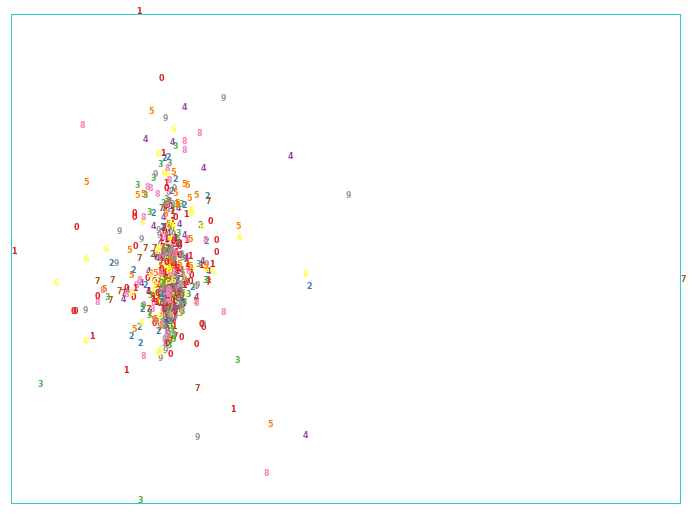

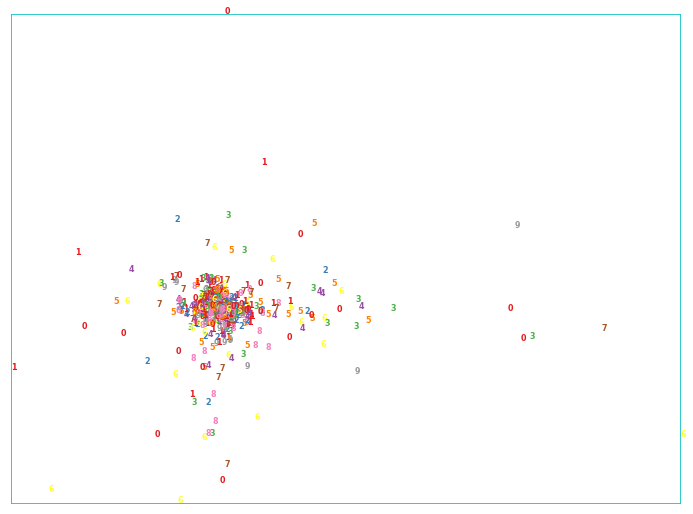

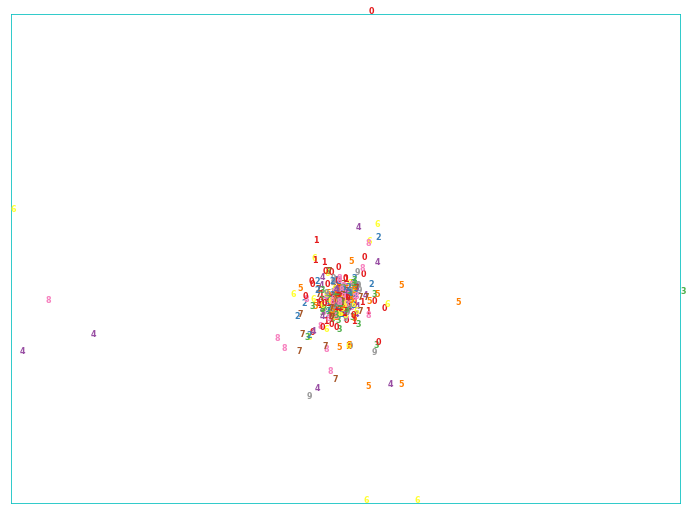

In [36]:
for i in range(1,52,10):
    X_kpca = decomposition.KernelPCA(n_components=2, kernel="rbf", gamma=i).fit_transform(X)
    plot_digits(X_kpca, digits.target)
#Using a kernel, the originally linear operations of PCA 
#are performed in a reproducing kernel Hilbert space.
#kernel - which one
#gamma - kernel rbf coeff

Isomap

manifold techniques - for non linear data

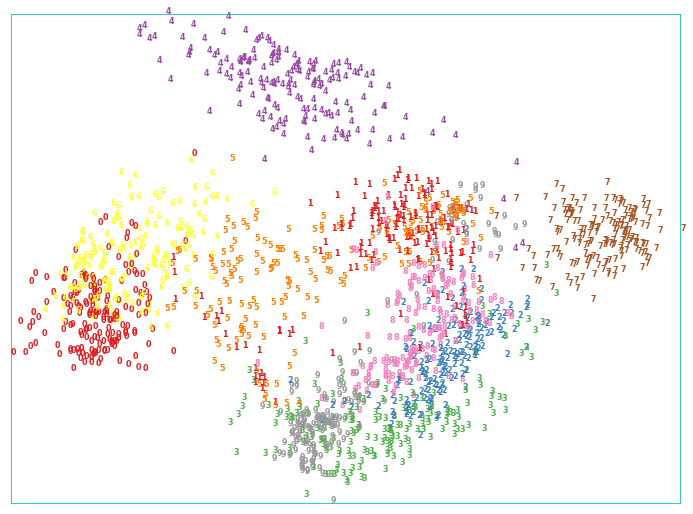

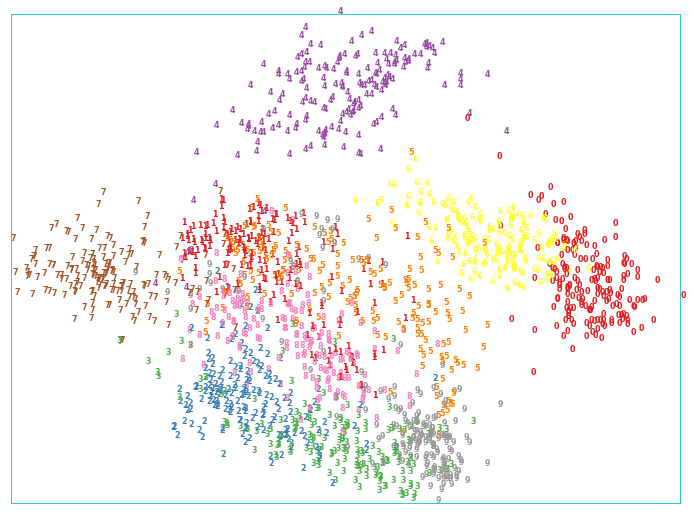

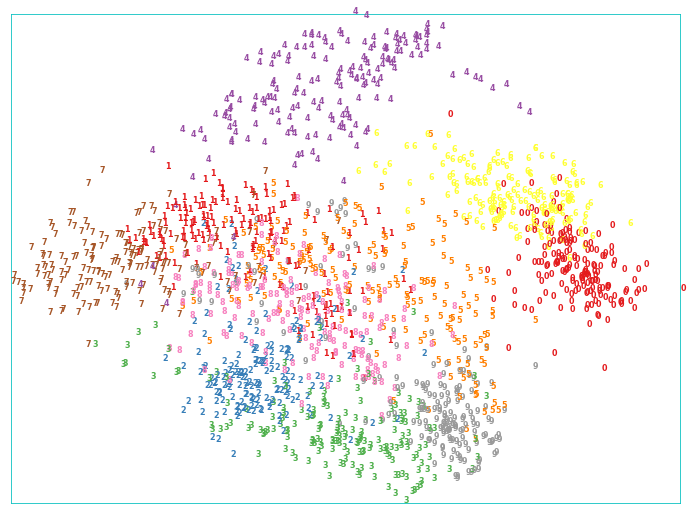

In [41]:
#isomap - mapping which preserves lengths
#how many neighbours tp consider~
for i in [15,30,60]:
    X_iso = manifold.Isomap(i, n_components=2).fit_transform(X)
    plot_digits(X_iso, digits.target)

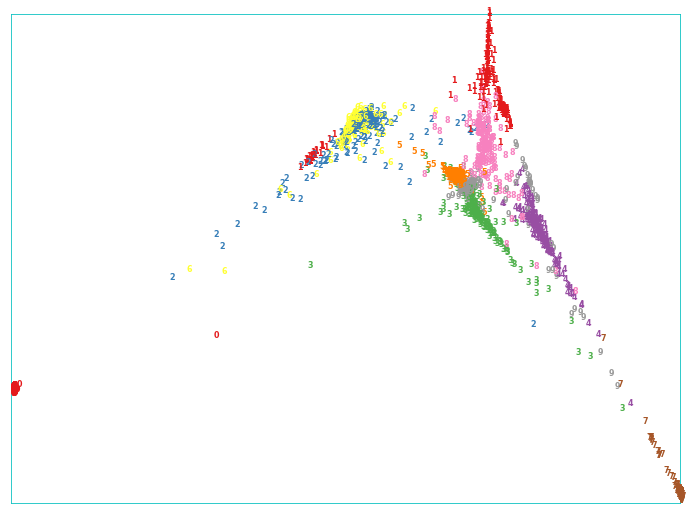

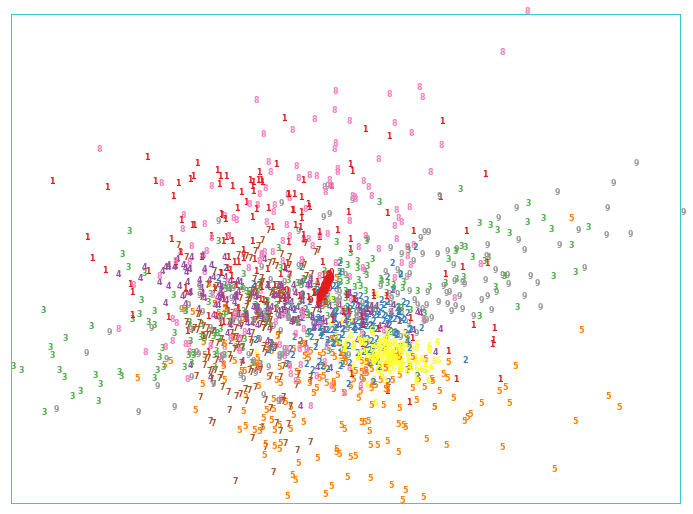

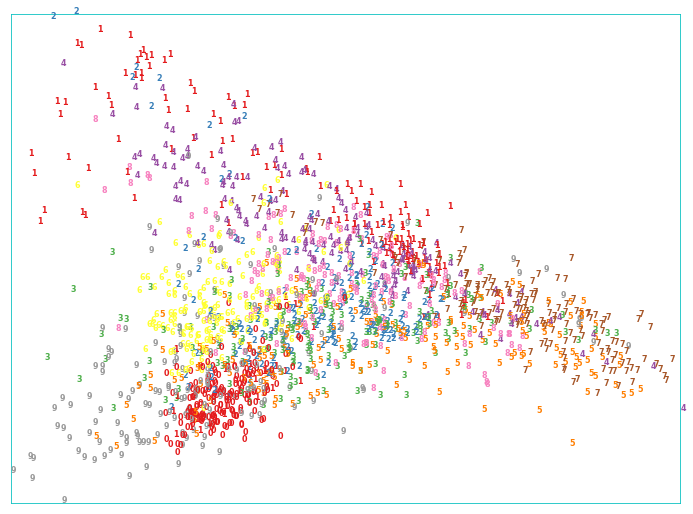

In [143]:
#Locally Linear Embedding (LLE)
#parameter no of neighbours
for i in [10,30,70]:
    X_lle = manifold.LocallyLinearEmbedding(i, n_components=2).fit_transform(X)
    plot_digits(X_lle, digits.target)

linar approach  - Multidimensional scaling - matrix of pair wise distances - preserves 
interpoint distances - upgrade to PCA

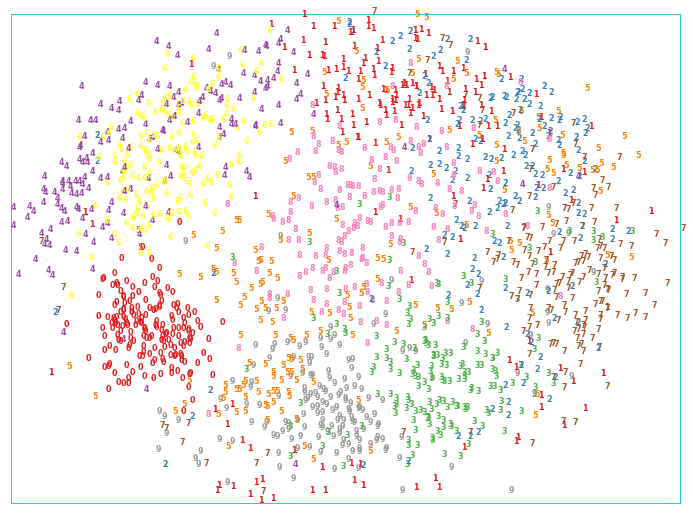

In [43]:
X_mds = manifold.MDS(n_components=2, n_init=1, max_iter=100).fit_transform(X)
plot_digits(X_mds, digits.target)

t-distributed stochastic neighbor embedding

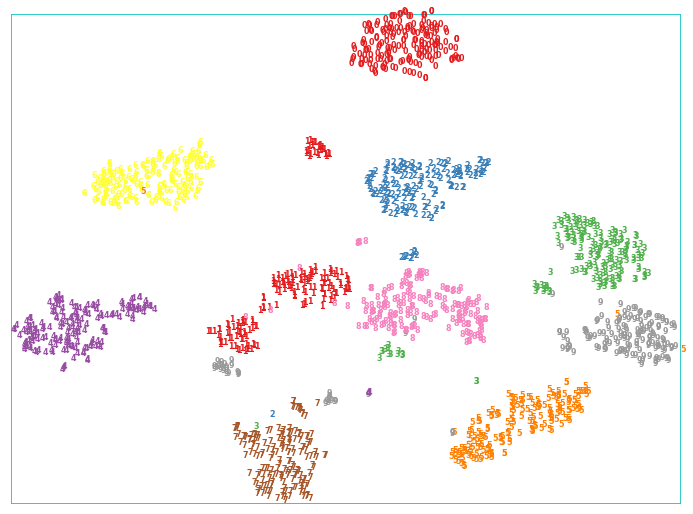

In [146]:
#It is a nonlinear dimensionality reduction technique well-suited 
#for embedding high-dimensional data for visualization in a low-dimensional space 
#of two or three dimensions. Specifically, it models each high-dimensional object by 
#a two- or three-dimensional point in such a way that similar objects are modeled 
#by nearby points and dissimilar objects are modeled by distant points with 
#high probability.
#init - of embedding
X_tsne = manifold.TSNE(n_components=2, init='random').fit_transform(X)
plot_digits(X_tsne, digits.target)

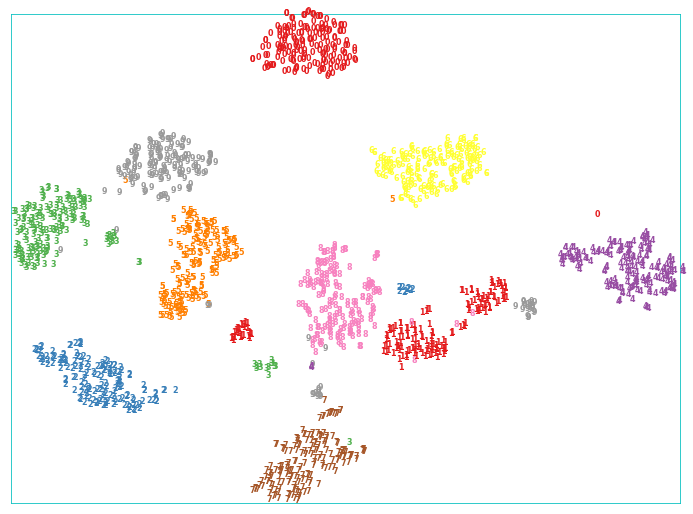

In [149]:
X_tsne = manifold.TSNE(n_components=2, init='pca').fit_transform(X)
plot_digits(X_tsne, digits.target)

Zadanie 7. (3 punkty)
Porównaj skuteczność klasyfikatora KNN działającego na oryginalnym zestawie danych
zawierającym obrazy cyfr pisanych ręcznie (użytym w skrypcie z poprzedniego zadania)
ze skutecznością klasyfikatorów KNN działających na zestawach danych zredukowanych
do dwóch wymiarów za pomocą metod PCA, KPCA, Isomap, LLE, MDS, t-SNE.

In [140]:
def KNN(train_X, train_Y, test_X, ks):
    train_X = train_X#.astype(np.float32)
    test_X = test_X#.astype(np.float32)
    preds = {}
    dists = (np.sum(train_X ** 2, axis=1)[:,np.newaxis] - 2 * np.dot(train_X,test_X.T) +
                np.sum(test_X ** 2, axis=1))
    closest = np.argsort(dists, axis=0) #sorting, returns indices
    targets = train_Y[closest]#
    for k in ks:
        predictions = sstats.mode(targets[:k])[0] #take k closest targets
        predictions = predictions.ravel()#flattened array
        preds[k] = predictions
    return preds#returns train examples targets

In [48]:
X_train, X_test, y_train, y_test = train_test_split(
    X, digits.target, test_size=0.33)
X_train.shape, X_test.shape

((1203, 64), (594, 64))

In [144]:
%%time
model = random_projection.SparseRandomProjection(n_components=2)
X_projected = model.fit_transform(X_train)
X_projected_t = model.transform(X_test)
model = decomposition.PCA(n_components=2,whiten=True)
X_pca = model.fit_transform(X_train)
X_pca_t = model.transform(X_test)
model = decomposition.KernelPCA(n_components=2, kernel="rbf", gamma=10)
X_kpca = model.fit_transform(X_train)
X_kpca_t = model.transform(X_test)
model = manifold.Isomap(20, n_components=2)
X_iso = model.fit_transform(X_train)
X_iso_t = model.transform(X_test)
model = manifold.LocallyLinearEmbedding(12, n_components=2)
X_lle = model.fit_transform(X_train)
X_lle_t = model.transform(X_test)


stacked_data = np.vstack([X_train, X_test])
model = manifold.MDS(n_components=2, n_init=1, max_iter=100, metric=True)
X_mds_t = model.fit_transform(stacked_data)[X_train.shape[0]:, :]
X_mds = model.fit_transform(stacked_data)[:X_train.shape[0], :]
model = manifold.TSNE(n_components=2, init='pca', perplexity=10)
X_tsne_t = model.fit_transform(stacked_data)[X_train.shape[0]:, :]
X_tsne = model.fit_transform(stacked_data)[:X_train.shape[0], :]

data = [X_train, X_projected, X_pca, X_kpca, X_iso, X_lle, X_mds, X_tsne]
data_t = [X_test, X_projected_t, X_pca_t, X_kpca_t, X_iso_t, X_lle_t, X_mds_t, X_tsne_t]
names = ['Original', 'Random', 'PCA', 'KPCA', 'Isomap', 'LLE', 'MDS', 't-SNE']

CPU times: user 2min 3s, sys: 3.47 s, total: 2min 7s
Wall time: 57.7 s


In [54]:
%%time
ks = np.arange(1, 22, 2)
all_preds = np.array([KNN(data[i], y_train, data_t[i], ks) for i in range(len(data))])

CPU times: user 7.93 s, sys: 87.6 ms, total: 8.02 s
Wall time: 3.21 s


In [55]:
res = defaultdict(list)
for i, preds in enumerate(all_preds):
    for k, p in preds.items():
        score = (p == y_test).mean()
        res[k].append(round(score,3))

In [58]:
df = pd.DataFrame.from_dict(res, orient='index', columns=names)
df

,OG,Random,PCA,KPCA,Isomap,LLE,MDS,t-SNE
1,0.983,0.281,0.582,0.096,0.685,0.768,0.172,0.971
3,0.983,0.283,0.591,0.101,0.734,0.779,0.157,0.975
5,0.978,0.298,0.618,0.101,0.747,0.795,0.170,0.973
7,0.980,0.308,0.636,0.099,0.746,0.813,0.177,0.975
9,0.976,0.306,0.643,0.103,0.764,0.808,0.180,0.973
11,0.975,0.310,0.646,0.101,0.766,0.813,0.178,0.970
13,0.978,0.320,0.631,0.101,0.753,0.810,0.172,0.966
15,0.971,0.323,0.626,0.101,0.759,0.805,0.177,0.965
17,0.966,0.327,0.631,0.103,0.766,0.801,0.173,0.963
19,0.965,0.340,0.633,0.103,0.771,0.798,0.175,0.958


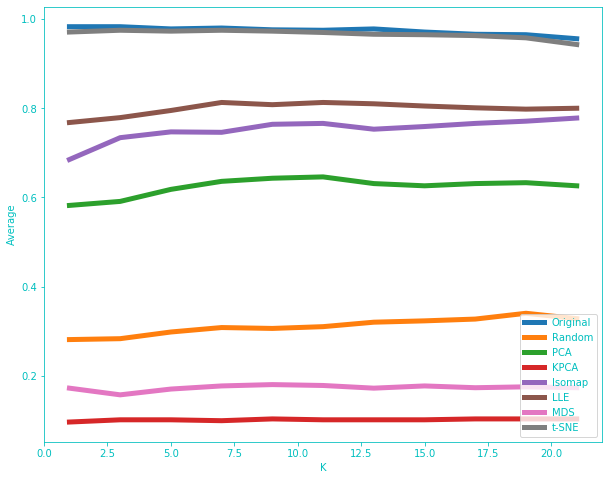

In [145]:
plt.figure(figsize=(10,8))
plt.xlabel('K')
plt.ylabel('Average')
for i, col in enumerate(df.columns):
    plt.plot(ks, df[col], label=names[i], linewidth=5.0)
plt.legend(loc='lower right', fontsize='medium')
#plt.legend()

In [138]:
def cc2 ( func , a , b ,N):
    bma = 0.5*(b-a)
    x = np.cos(np.pi * np.linspace (0 ,N,N+1) /N) # Chebyshev points
    #print(x)
    #print(x.shape)
    x *= bma
    x += 0.5*(a+b)
    fx = func(x) *0.5/N
    vx = np.hstack ((fx, fx[-2:0:-1]) )
    
    g = np.real(np.fft.fft(vx))
    A = np.zeros(N+1)
    A[0] = g[0] ; A[N] = g[N]
    A[1:N] = g[1:N] + np.flipud(g[N+1: ])
    #w = 0.*x
    #w[ : :2] = 2./(1.-np.r_[ : N+1:2]**2)
    print(A)
    print(A.shape)
    #return np.dot(w,A) *bma

In [139]:
cc2(f2, -1,1, 127)

[ 6.45035270e-01 -7.45367759e-18 -3.12841606e-01 -6.82176754e-18
  3.87041154e-02  7.43872920e-18 -3.20868302e-03 -4.40012025e-17
  1.99919238e-04  3.63610080e-17 -9.97521104e-06  1.41600710e-17
  4.15016897e-07 -2.35909000e-17 -1.48055223e-08 -2.24352563e-17
  4.62271547e-10 -1.50072678e-17 -1.28319496e-11 -6.70754957e-18
  3.20635698e-13  4.77153767e-18 -7.31720634e-15  2.07313478e-17
  1.46155510e-16  1.47911246e-17 -5.79133639e-18  2.25082509e-17
 -9.31851306e-18  5.13937595e-18 -3.32953458e-18 -2.70272654e-17
  6.17708832e-17  1.37467484e-17 -1.99626503e-17 -2.14997114e-17
  8.91268694e-19  2.07908912e-18  4.04182089e-17  1.86469697e-17
  2.63945856e-17 -5.92672342e-18  2.70214558e-17 -3.67805857e-18
 -2.62416048e-18 -3.00924914e-17 -4.85547722e-18  2.94029400e-17
  5.11770469e-17 -1.07482233e-17  5.60108107e-18 -2.20592430e-17
  7.62644470e-18 -1.74998847e-20 -2.04064522e-17  6.37046717e-18
  2.21622080e-17  1.64552184e-17 -1.77219930e-18 -1.88871060e-17
 -1.42079823e-17  1.03157

In [127]:
AA = np.arange(1,100)
AA =AA[-2:0:-1]
print(AA)

[98 97 96 95 94 93 92 91 90 89 88 87 86 85 84 83 82 81 80 79 78 77 76 75
 74 73 72 71 70 69 68 67 66 65 64 63 62 61 60 59 58 57 56 55 54 53 52 51
 50 49 48 47 46 45 44 43 42 41 40 39 38 37 36 35 34 33 32 31 30 29 28 27
 26 25 24 23 22 21 20 19 18 17 16 15 14 13 12 11 10  9  8  7  6  5  4  3
  2]


In [109]:
def fun1(x):
    return math.exp(-x*x)
f2 = np.vectorize(fun1)

In [87]:
import math